# Module 17: Practical Project - Complete ANN

**Building a Production-Ready Neural Network**

---

## Project: Binary Classification on Synthetic Data

In this project, we'll build a complete neural network using everything we've learned.

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

---

# Step 1: Create Dataset

---

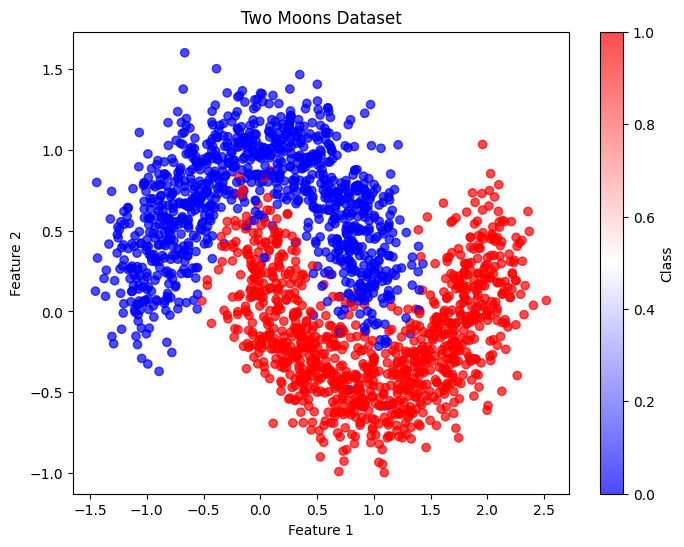

Dataset: 2000 samples, 2 features


In [2]:
# Generate synthetic dataset
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Two Moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.show()

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")

In [3]:
# Create datasets and loaders
dataset = TensorDataset(X, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 1400, Val: 300, Test: 300


---

# Step 2: Build Model

---

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout=0.2):
        super().__init__()

        layers = []
        in_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_size = hidden_size

        layers.append(nn.Linear(in_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size=2, hidden_sizes=[32, 32], output_size=2, dropout=0.2).to(device)

print(f"Device: {device}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Device: cpu
Parameters: 1,346


---

# Step 3: Training Loop

---

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)

        total_loss += loss.item() * X.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

In [6]:
# Train
n_epochs = 50
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:2d} | Train: {train_loss:.4f}/{train_acc:.3f} | Val: {val_loss:.4f}/{val_acc:.3f}")

Epoch 10 | Train: 0.1460/0.940 | Val: 0.0829/0.957
Epoch 20 | Train: 0.1806/0.936 | Val: 0.0773/0.970
Epoch 30 | Train: 0.1590/0.936 | Val: 0.0880/0.963
Epoch 40 | Train: 0.1439/0.944 | Val: 0.0766/0.967
Epoch 50 | Train: 0.1380/0.952 | Val: 0.0731/0.977


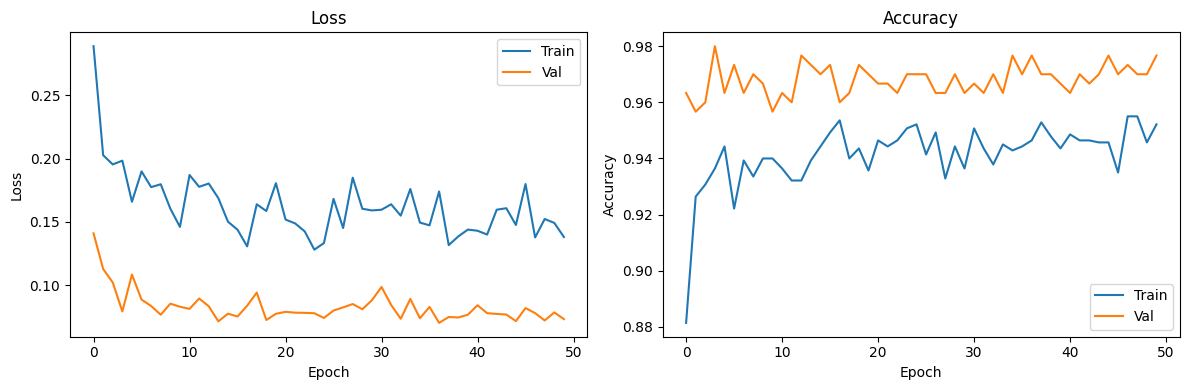

In [7]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

---

# Step 4: Final Evaluation

---

In [8]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.3f}")

Test Loss: 0.0846
Test Accuracy: 0.983


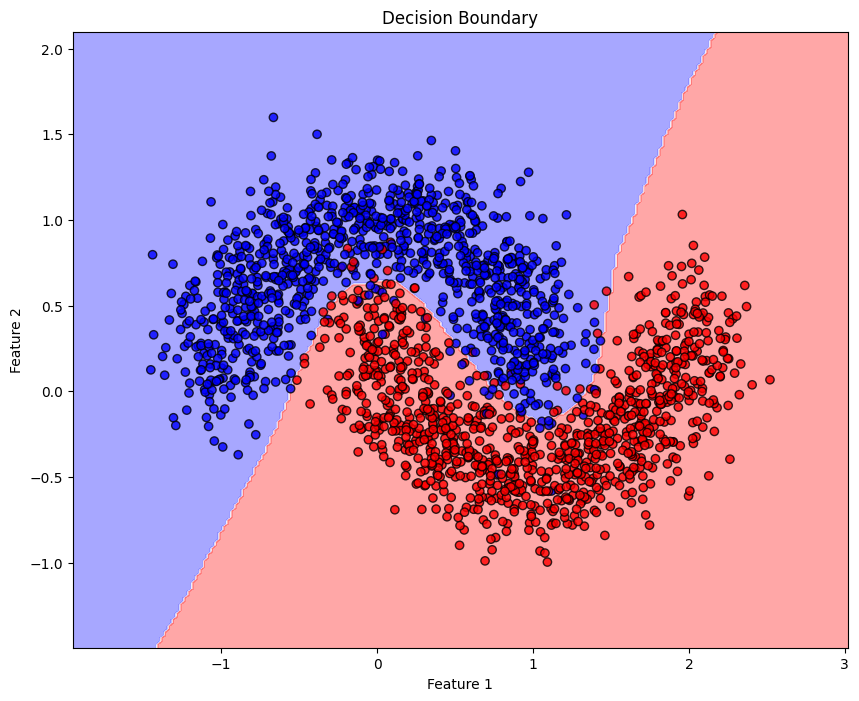

In [9]:
# Visualize decision boundary
@torch.no_grad()
def plot_decision_boundary(model, X, y):
    model.eval()

    # Create mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Predict on mesh
    mesh = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    Z = model(mesh).argmax(dim=1).cpu().numpy().reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.8, edgecolors='k')
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

plot_decision_boundary(model, X.numpy(), y.numpy())

---

# Summary

In this project, we:
1. Created a synthetic dataset
2. Built an MLP with BatchNorm, Dropout, and He initialization
3. Trained with Adam optimizer and LR scheduling
4. Evaluated on test set and visualized the decision boundary

---

## Next Module: [18 - Capstone](../18_capstone/18_capstone.ipynb)